# **Praktikum 1**

---

### Langkah 1 - Impor _Library_

Impor _library_ yang dibutuhkan sebagai berikut,


In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from typing import List

import pandas as pd

### Langkah 2 - _Load_ Data dan Pengelompokan Data

_Load_ data `Titanic-Dataset.csv` menggunakan `pandas`. Selanjutnya, kita akan memisahkan variabel target, yaitu `Survived` dan mengelompokkan data berdasarkan data numerik dan kategorikal.

In [64]:
# Load Data
df = pd.read_csv("Titanic-Dataset.csv") # type: ignore

# Pisahkan Survived
X = df.drop(columns=["Survived"])
y = df["Survived"].astype(int)

# Buat list variabel numerik dan kategorikal
# Akan digunakan untuk proses seleksi fitur
# Name tidak akan digunakan karena tidak relevan
num_cols: List[str] = ["Age", "SibSp", "Parch", "Fare"]
cat_cols: List[str] = ["Pclass", "Sex", "Embarked"]

### Langkah 3 - Ekstraksi Fitur

Pada tahap ini, kita akan melakukan ekstraksi fitur berdasarkan jenis data untuk setiap variabel. Selain itu, kita akan mencoba menggunakan `Pipeline` dari _scikit-learn_ untuk proses ekstraksi fiturnya. `Pipeline` merupakan model proses yang dapat kita gunakan berkali kali sehingga memudahkan proses pembuatan model.

In [65]:
# Ekstaksi Fitur dengan Pipeline

# Data Numerik
num_tf = Pipeline([
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", StandardScaler())
])

# Data Kategorikal
cat_tf = Pipeline([
  ("imputer", SimpleImputer(strategy="most_frequent")),
  ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

### Langkah 3.1 - _Feature Construction_

Selain menggunakan variabel-variabel yang sudah ada, sebetulnya kita dapat membuat fitur baru dalam data tabular berdasarkan proses agregasi atau penggabungan dari variabel-variabel yang lain. Langkah ini disebut sebagai _feature construction_. 

Kita akan membuat fitur bernama FamiliSize yang merupakan jumlah keluarga yang dapat dihitung berdasarkan `SibSp + Parch + 1`. _SipSp_ merupakan data terkait dengan jumlah _siblings_ dan _spouse_. Sedangkan _Parch_ adalah data terkait dengan jumlah orang tua atau anak.

In [66]:
# Buat Fitur FamilySize
X["FamilySize"] = X["SibSp"].fillna(0) + X["Parch"].fillna(0) + 1 # pyright: ignore[reportUnknownMemberType]

# Tambahkan FamilySize pada kelompok numerikal
preprocess = ColumnTransformer([
    ("num", num_tf, num_cols + ["FamilySize"]),
    ("cat", cat_tf, cat_cols),
])

### Langkah 4 - Seleksi Fitur

Kita akan melakukan proses seleksi fitur sederhana dengan menggunakan fungsi `SelectKBest`. Fungsi ini menggunakan metode _univariate statistics_ dalam proses pemilihan fiturnya. Jumlah fitur yang digunakan sesuai dengan jumlah `k` yang digunakan. 

In [67]:
# Seleksi fitur dengan SelectKBest
# Fungsi tersebut akan menggunakan analisis variance
# Baca: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

from sklearn.feature_selection import f_classif
selector_filter = SelectKBest(score_func=f_classif, k=5)

pipe_filter = Pipeline([
    ("prep", preprocess), # menjalankan pipeline preprocessing
    ("sel", selector_filter), # menjalankan pipeline seleksi fitur
    ("clf", LogisticRegression(max_iter=1000)) # uji dengan model sederhana -> Logistic Regression
])

### Langkah 5 - Uji dengan Model

Pada langkah ini kita akan melakukan uji langsung dengan melakukan proses pelatihan menggunakan model _Logistic Regression_ untuk mengetahui hasil dari proses ekstraksi dan seleksi fitur terhadap nilai akurasi.

In [68]:
# Lakukan pelatihan dan uji model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) # pyright: ignore[reportUnknownVariableType]

pipe_filter.fit(X_train, y_train) # pyright: ignore[reportUnknownMemberType, reportUnknownArgumentType]
pred = pipe_filter.predict(X_test) # pyright: ignore[reportUnknownMemberType, reportUnknownArgumentType]
print("=== Filter (ANOVA) + LR ===")
print("Accuracy:", accuracy_score(y_test, pred)) # pyright: ignore[reportUnknownArgumentType]
print(classification_report(y_test, pred)) # pyright: ignore[reportUnknownArgumentType]

=== Filter (ANOVA) + LR ===
Accuracy: 0.776536312849162


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179



Berdasarkan informasi tersebut, kita mengetahui tingkat akurasi yang didapatkan sekitar 0.78 atau 78%. Hasilnya cukup baik namun tidak terlalu baik untuk mengetahui penumpang yang meninggal atau tidak. Hal ini erat kaitannya dengan fitur yang digunakan.

In [69]:
# 1) Nama fitur setelah preprocess
feat_names = pipe_filter.named_steps["prep"].get_feature_names_out() # type: ignore
print("Nama fitur:", feat_names) # type: ignore
print("\n")

# 2) Mask & skor fitur terpilih (SelectKBest)
sel = pipe_filter.named_steps["sel"] # type: ignore
mask = sel.get_support() # type: ignore
selected_names = feat_names[mask] # type: ignore
selected_scores = sel.scores_[mask] # type: ignore
top = sorted(zip(selected_names, selected_scores), key=lambda t: t[1], reverse=True)[:10] # type: ignore
print("Top fitur:", top) # type: ignore

Nama fitur: ['num__Age' 'num__SibSp' 'num__Parch' 'num__Fare' 'num__FamilySize'
 'cat__Pclass_1' 'cat__Pclass_2' 'cat__Pclass_3' 'cat__Sex_female'
 'cat__Sex_male' 'cat__Embarked_C' 'cat__Embarked_Q' 'cat__Embarked_S']


Top fitur: [('cat__Sex_female', np.float64(306.5932488951883)), ('cat__Sex_male', np.float64(306.59324889518797)), ('cat__Pclass_3', np.float64(80.33862734392042)), ('cat__Pclass_1', np.float64(73.99727564291717)), ('num__Fare', np.float64(58.31490728198491))]


Kita dapat mengetahui bahwa akurasi 78% didapatkan dari fitur,

1. Sex_female
2. Sex_make
3. P_class_3
4. P_class_1
5. Fare

Selanjutnya, Anda dapat melakukan percobaan dengan menggunakan konfigurasi `k` yang berbeda atau metode yang berbeda untuk mendapatkan fitur dengan hasil terbaik.

# **Praktikum 2**

---

### Langkah 0 - Siapkan Corpus

In [70]:
corpus = [
    'the house had a tiny little mouse',
    'the cat saw the mouse',
    'the mouse ran away from the house',
    'the cat finally ate the mouse',
    'the end of the mouse story'
]

### Langkah 1 - Buat Model TF-IDF

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisiasi obyek TFidfVectorizer
vect = TfidfVectorizer(stop_words='english')

# Pembobotan TF-IDF
resp = vect.fit_transform(corpus) # type: ignore

# Cetak hasil
print(resp)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 18 stored elements and shape (5, 12)>
  Coords	Values
  (0, 5)	0.47557510189256375
  (0, 11)	0.5894630806320427
  (0, 6)	0.5894630806320427
  (0, 7)	0.2808823162882302
  (1, 7)	0.3477147117091919
  (1, 2)	0.5887321837696324
  (1, 9)	0.7297183669435993
  (2, 5)	0.47557510189256375
  (2, 7)	0.2808823162882302
  (2, 8)	0.5894630806320427
  (2, 1)	0.5894630806320427
  (3, 7)	0.2808823162882302
  (3, 2)	0.47557510189256375
  (3, 4)	0.5894630806320427
  (3, 0)	0.5894630806320427
  (4, 7)	0.3193023297639811
  (4, 3)	0.6700917930430479
  (4, 10)	0.6700917930430479


Hasil tersebut menunjukkan,

1. (row, column) -> Row indeksmerupakan dokumen didalam corpus, sedangkan column merupakan indeks kata didalam fitur
2. Values -> bobot hasil proses vektorisasi pada TF-IDF

### Langkah 2 - Cek Kata yang Digunakan

In [72]:
print(vect.get_feature_names_out())

['ate' 'away' 'cat' 'end' 'finally' 'house' 'little' 'mouse' 'ran' 'saw'
 'story' 'tiny']


Indeks kata dari _list_ tersebut yang digunakan pada hasil sebelumnya.

# **Praktikum 3**

---

Pada pratikum ini, kita akan mencoba untuk mengekstraksi fitur dari sebuah citra. Proses yang akan kita lakukan hanya proses sederhana. Pembahasan lengkap terkait dengan pra pengolahan data dan ekstraksi fitur pada data citra akan dibahas pada perkuliahan pengolahan citra digital.

### angkah 1 - _Load Image_

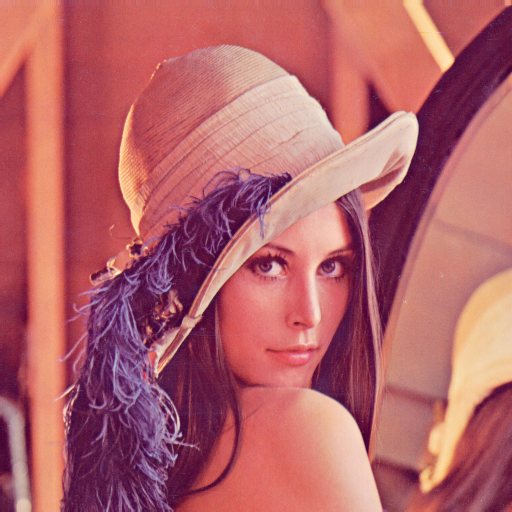

In [73]:
from PIL import Image
 
img = Image.open('lenna.png')
img.show() # tampilkan gambar
display(img) # metode alternatif tampilkan gambar

### Langkah 2 - Ekstrak Fitur

In [74]:
# Ekstrak setiap channel red, green, blue
r, g, b = img.split()

# Cek panjang ukuran channel red
print(len(r.histogram()))

# Cetak fitur histogram pada channel red
print(r.histogram())

256
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 8, 6, 10, 9, 20, 37, 32, 41, 53, 74, 103, 132, 179, 193, 242, 238, 336, 386, 404, 483, 607, 628, 771, 785, 1001, 1016, 1177, 1269, 1332, 1446, 1487, 1457, 1574, 1585, 1591, 1557, 1569, 1660, 1648, 1420, 1559, 1418, 1384, 1319, 1342, 1156, 1120, 955, 969, 828, 782, 752, 737, 719, 700, 628, 673, 587, 617, 610, 592, 557, 593, 552, 566, 582, 559, 571, 520, 664, 650, 618, 730, 594, 667, 675, 685, 771, 715, 667, 740, 744, 766, 765, 772, 817, 817, 744, 806, 760, 777, 812, 797, 799, 861, 814, 910, 907, 918, 888, 1011, 879, 996, 912, 952, 884, 1074, 977, 1073, 1040, 1216, 1250, 1403, 1534, 1639, 1682, 1776, 1874, 1769, 1582, 1743, 1441, 1477, 1483, 1409, 1437, 1449, 1389, 1479, 1592, 1655, 1657, 1666, 1857, 1896, 1813, 1979, 1814, 1956, 1928, 2055, 2012, 2303, 2333, 2670, 2787, 3232, 3154, 3476, 3424, 3516, 3102, 31